실제 부하 + 예측 부하 불러오기

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data_csv/amiwea.csv", parse_dates=["timestamp"])
df = df.set_index("timestamp").sort_index()
pred = pd.read_csv("../data_csv/XGB테스트.csv", parse_dates=["timestamp"])
pred = pred.set_index("timestamp")

In [10]:
# 예측 결과만 사용
test = pred.copy()
test.head()

,actual,pred_xgb
timestamp,,
2013-12-18 05:00:00,5.545,6.632373
2013-12-18 06:00:00,12.552,7.825272
2013-12-18 07:00:00,13.082,12.941123
2013-12-18 08:00:00,19.054,11.586874
2013-12-18 09:00:00,7.159,12.513745


2) 운영 시뮬레이션 공통 규칙 정의

핵심 아이디어
	•	예측 없음(naive): 실제값이 임계치 넘으면 “사후”로만 초과 발생
	•	예측 있음(predictive): 예측이 임계치 넘을 것 같으면 “선제”로 완화 조치(가상의 제어) 적용

여기서 “완화 조치”는 실제 제어가 아니라 단순 운영 가정으로 처리:
	•	예측 기반 운영에서는 피크 직전/피크 구간에서 부하를 일정 비율만큼 낮춘 것처럼 시뮬레이션

In [11]:
# 피크 기준선: actual 상위 5%를 피크로 정의
threshold = test["actual"].quantile(0.95)

# 예측 기반 완화 강도 (가정): 10% 감축
alpha = 0.10

시나리오A - 예측 없음 

In [12]:
# 예측 없는 운영
test["load_naive"] = test["actual"]

시나리오B - 예측 

In [13]:
# 예측이 임계치 초과로 예상되면 선제적으로 부하 완화
test["load_predictive"] = np.where(
    test["pred_xgb"] > threshold,
    test["actual"] * (1 - alpha),
    test["actual"]
)

Peak Shaving 효과 평가 

In [14]:
peak_naive = (test["load_naive"] > threshold).sum()
peak_predictive = (test["load_predictive"] > threshold).sum()

peak_naive, peak_predictive

(np.int64(88), np.int64(87))

Ramp Smoothing 효과 평가 

In [15]:
ramp_naive = test["load_naive"].diff().abs().mean()
ramp_predictive = test["load_predictive"].diff().abs().mean()

ramp_naive, ramp_predictive

(np.float64(4.341395189003437), np.float64(4.336684650630012))

시계열 비교 그래프

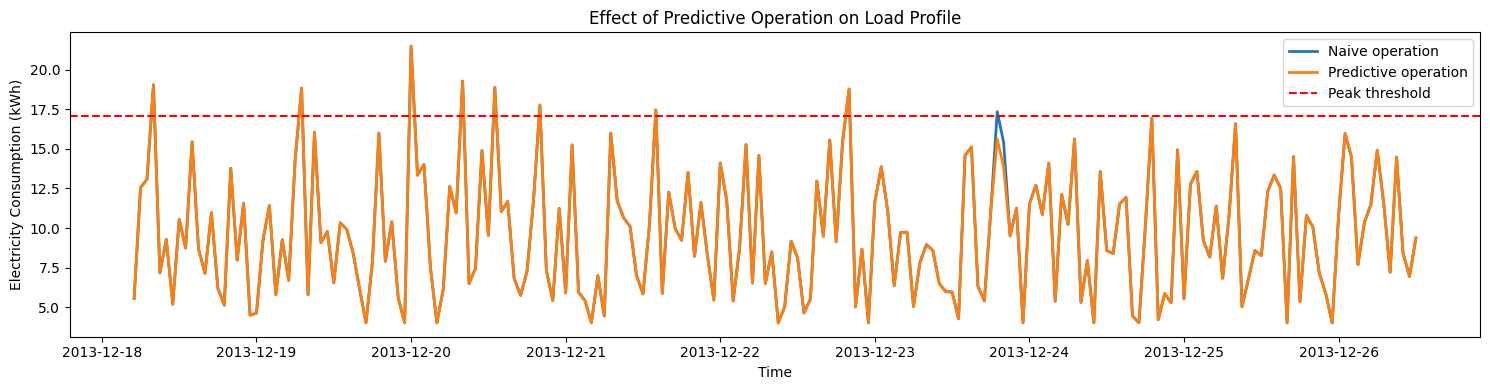

In [16]:
plt.figure(figsize=(15, 4))

plt.plot(
    test.index[:200],
    test["load_naive"][:200],
    label="Naive operation",
    linewidth=2
)

plt.plot(
    test.index[:200],
    test["load_predictive"][:200],
    label="Predictive operation",
    linewidth=2
)

plt.axhline(
    threshold,
    color="red",
    linestyle="--",
    label="Peak threshold"
)

plt.legend()
plt.title("Effect of Predictive Operation on Load Profile")
plt.xlabel("Time")
plt.ylabel("Electricity Consumption (kWh)")
plt.tight_layout()
plt.show()

결과 요약

In [17]:
result_summary = pd.DataFrame({
    "Scenario": ["Naive", "Predictive"],
    "Peak Exceedance Count": [peak_naive, peak_predictive],
    "Average Ramp (ΔLoad)": [ramp_naive, ramp_predictive]
})

result_summary

,Scenario,Peak Exceedance Count,Average Ramp (ΔLoad)
0,Naive,88,4.341395
1,Predictive,87,4.336685


해당 코드를 통해 
	•	예측 없음 vs 예측 있음 운영 비교
	•	Peak shaving 정량 평가
	•	Ramp smoothing 정량 평가
	•	Grid-forming 제어의 전제 조건(예측 기반 안정화) 검증
